In [90]:
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
import keras
#from keras.optimizers.experimental import AdamW
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, BatchNormalization
from keras.utils import np_utils

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [ ]:
# dla = pd.read_csv('list_dlas.csv')
# dla = dla[['FILE', 'Z_ABS', 'Z_QSO']]
# for i in range(0, dla.shape[0]):
#     dla['FILE'][i] = dla['FILE'][i].replace("output/abs_templates/PAQS_absorber_", "")
#     dla['FILE'][i] = dla['FILE'][i].replace(".fits", "")
#     dla['FILE'][i] = dla['FILE'][i].lstrip('0')
# #print(pd.DataFrame(zabs))
# dla['WAVE'] = round((dla['Z_ABS']+1)*1215.67*4)/4
# dla['IND'] = (dla['WAVE']-3671.5)*4
# print(dla['IND'].min())
# print(dla['IND'].max())
# dla.to_csv('dla_legacy.csv')

In [2]:
#reading the flux data (X) and applying the noise reduction
X = pd.read_pickle('spectra_list.pkl')
X = X['FLUX']
#X = X.apply(savgol_filter,  window_length=31, polyorder=2)
X = np.array([np.array(xi) for xi in X])
X = np.asarray(X).astype('float32')
X = X[:, 0:10000]
X = NormalizeData(X)
print(X.shape)
X_mean = []
for i in range(0, X.shape[0]):
    df = pd.DataFrame({'x': X[i]})
    df = df.x.rolling(100, center=True).median()
    df = df.dropna()
    X_mean.append(df)
X_mean = np.asarray(X_mean)
print(X_mean.shape)

(10000, 10000)
(10000, 9901)


In [72]:
#importing the dla locations and labelling the ranges of what is considered the DLA
dla = pd.read_csv('dla_legacy.csv')
dla = dla.loc[:, ~dla.columns.str.contains('^Unnamed')]
#dla = dla[dla['IND'] > 700]
#dla = dla.reset_index()
y_spec = np.zeros(X_mean.shape)
st = 400
for i in range(0, dla['FILE'].shape[0]): #for all of the DLAs:
    fileno = int(dla['FILE'][i]) #ind is equal to the file number
    ind = int(dla['IND'][i]) #this is the indices at which the dla is located in flux data
    if ind-st < 0:
        a = np.full(ind+st, 1)
        y_spec[(fileno-1)][:(ind+st)] = a
    elif ind+st > X_mean.shape[1]:
        a = np.full(X_mean.shape[1]-ind, 1)
        y_spec[(fileno-1)][ind:] = a
    else:
        a = np.full(2*st, 1)
        y_spec[(fileno-1)][(ind-st):(ind+st)] = a

In [73]:
#creating cuts of DLAs, which are 'perfect' cuts directly centered on the DLA
x=0
dla_seg = []
for i in range(0, dla['FILE'].shape[0]):
    fileno = int(dla['FILE'][i])-1
    ind = int(dla['IND'][i])
    if ind < 700:
        x+=1
    else:
        if ind-st < 0:
            l = 0
            u = 2*st
        elif ind+st > X_mean.shape[1]:
            l = X_mean.shape[1] - 2*st
            u = X_mean.shape[1]
        else:
            l = ind-st
            u = ind+st
            
        cut = X_mean[fileno][l:u]
        dla_seg.append(cut)
dla_seg = np.asarray(dla_seg)
print(dla_seg.shape)
print(x)
    

(5087, 3200)
474


1084.0


Text(1000, 0.2, '1084')

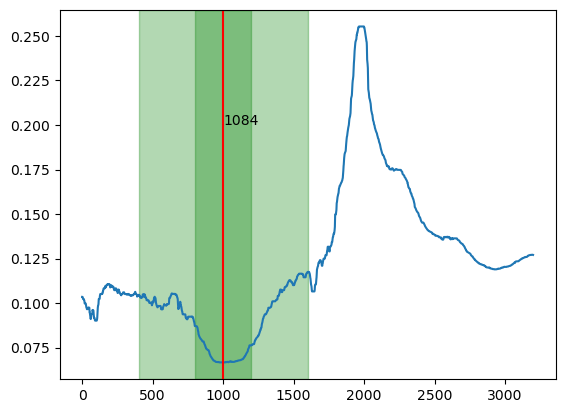

In [103]:
import importlib
importlib.reload(plt)
plt.plot(dla_seg[1])
plt.axvspan(400, 1200, alpha=0.3, color="g")
plt.axvspan(800, 1600, alpha=0.3, color="g")
plt.axvline(1000, color="r")
print(dla['IND'][1])

plt.annotate("1084", (1000, 0.2))
#plt.xticks([])
#plt.xticks([])

1084.0
2
-566.0


ValueError: could not broadcast input array from shape (3200,) into shape (0,)

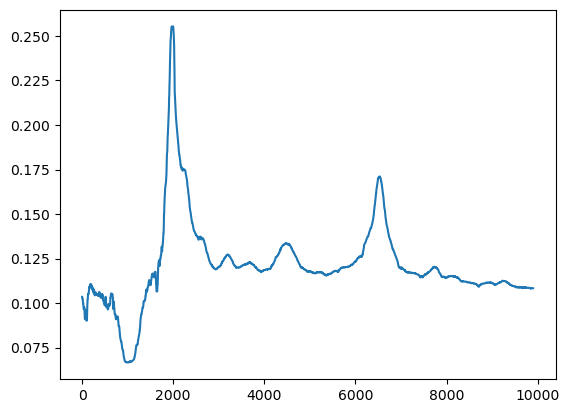

In [98]:
#plotting the dla position and the range of the cut we're using. a is the index of the dlas present (there are like 5000)
a = 1
c = dla['FILE'][a]
plt.plot(X_mean[c-1])
print(dla['IND'][a])
print(c-1)
ind = dla['IND'][a]-50
ind2 = dla['IND'][a+1]-50
print(ind-st)
val = np.zeros(X_mean[c-1].shape[0])
b = np.full(2*st, 1)
val[(int(ind-st)):(int(ind+st))] = b
plt.xlabel('index')
plt.ylabel('relative flux')
plt.title('spectra ' + str(c))
plt.plot([ind, ind],[0, 1], label='DLA', color='orange')
plt.plot([ind2, ind2],[0, 1], color='orange')
#plt.plot(val, label='DLA cut range')
plt.legend()
plt.ylim(X_mean[c-1].min(), 0.12)
plt.show()

In [5]:
#creating the segments 
segments = []
labels = []
period = 800 #size of each segment
step_size = 400 #steps between one segment and the next. if period=step_size, there is no overlap
x = 0
for n in range(0, X_mean.shape[0]):
    for i in range(0, X_mean.shape[1], step_size):
        if i+2*period > X_mean.shape[1]:
            break
        else:
            cut = X_mean[n][i:(i+period)]
            #lab = y_spec[i:(i+period)]  #could do it this method, but we just want to see if the dla is in the current cut or not
            segments.append(cut)
            unique, counts = np.unique(y_spec[n][i:(i+period)], return_counts=True)
            if len(unique) == 2 and counts[1] > 150:#1 in y_spec[n][i:(i+period)]: #counts[1] > 150 is where to change the condition of what counts as a DLA
                labels.append(1)
            else:
                labels.append(0)
segments = np.asarray(segments) #there are 19 segments per spectra at the moment, so it should be easy to reconstruct them later
print(segments.shape)
labels = np.asarray(labels)
print(labels.shape)
print(np.unique(labels, return_counts=True))

(210000, 800)
(210000,)
(array([0, 1]), array([194640,  15360], dtype=int64))


In [6]:
#picking out the non-DLA segments of equal size to the DLA segments (could have done randomly tbh)
counter = 0
noise_seg = []
noise_label = np.zeros(dla_seg.shape[0])
for i in range(102127, labels.shape[0]):
    if labels[i] == 0 and counter < dla_seg.shape[0]:
        noise_seg.append(segments[i])
        counter+=1
noise_seg = np.asarray(noise_seg)
print(noise_seg.shape)
print(noise_label.shape)

(5087, 800)
(5087,)


In [7]:
#adding the two segments together, doubled it to see if it had an effect (it did)
data = np.concatenate([dla_seg, noise_seg, dla_seg, noise_seg])
dla_label = np.full(dla_seg.shape[0], 1)
data_label = np.concatenate([dla_label, noise_label, dla_label, noise_label])
print(data.shape)
print(data_label.shape)

(20348, 800)
(20348,)


In [49]:
#split into test and train data, and normalised again to see if it had a big effect
input_train, input_test, truth_train, truth_test = train_test_split(data, data_label, test_size=0.25, random_state=42)
# input_train = NormalizeData(input_train)
# input_test = NormalizeData(input_test)
print(input_train.shape)
print(truth_train.shape)
print(period)

(15261, 800)
(15261,)
800


In [9]:
#learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * math.exp(-0.1)
        

In [14]:
model_m = Sequential()
model_m.add(Conv1D(100, 32, activation='relu', input_shape=(period, 1))) #size of each cut
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(BatchNormalization(axis=-1, momentum=0.09, epsilon=0.001))
model_m.add(MaxPooling1D(1))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(BatchNormalization(axis=-1, momentum=0.09, epsilon=0.001))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(1, activation='sigmoid'))
print(model_m.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 769, 100)          3300      
                                                                 
 conv1d_1 (Conv1D)           (None, 760, 100)          100100    
                                                                 
 batch_normalization (BatchN  (None, 760, 100)         400       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 760, 100)         0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 751, 160)          160160    
                                                                 
 conv1d_3 (Conv1D)           (None, 742, 160)          2

In [15]:
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=10000,
#     decay_rate=0.9)

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='/output/bestm/best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss'),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=3),
    (keras.callbacks.LearningRateScheduler(scheduler))
]
opt = keras.optimizers.Adam(1e-03)#1e-03) #2e-04 #best result 1e-03 = 88%
model_m.compile(loss='binary_crossentropy',
                optimizer=opt, metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 30

In [235]:
history = model_m.fit(input_train,
                      truth_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
31/31 [==============================] - 243s 8s/step - loss: 0.5786 - accuracy: 0.7309 - val_loss: 0.5513 - val_accuracy: 0.7141 - lr: 0.0010
Epoch 2/30
31/31 [==============================] - 225s 7s/step - loss: 0.4843 - accuracy: 0.7850 - val_loss: 0.4921 - val_accuracy: 0.7543 - lr: 0.0010
Epoch 3/30
31/31 [==============================] - 207s 7s/step - loss: 0.4481 - accuracy: 0.8073 - val_loss: 0.4475 - val_accuracy: 0.8104 - lr: 0.0010
Epoch 4/30
31/31 [==============================] - 204s 7s/step - loss: 0.4460 - accuracy: 0.8112 - val_loss: 0.4732 - val_accuracy: 0.7688 - lr: 9.0484e-04
Epoch 5/30
31/31 [==============================] - 221s 7s/step - loss: 0.4330 - accuracy: 0.8169 - val_loss: 0.4304 - val_accuracy: 0.8192 - lr: 8.1873e-04
Epoch 6/30
31/31 [==============================] - 204s 7s/step - loss: 0.4238 - accuracy: 0.8261 - val_loss: 0.4420 - val_accuracy: 0.8189 - lr: 7.4082e-04
Epoch 7/30
31/31 [==============================] - 205s 7s/step

In [226]:
model_m.evaluate(input_test,
                      truth_test,
                      batch_size=BATCH_SIZE,
                      callbacks=callbacks_list,
                      verbose=1)

13/13 [==============================] - 15s 1s/step - loss: 0.4403 - accuracy: 0.8622


[0.4403345286846161, 0.862197756767273]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


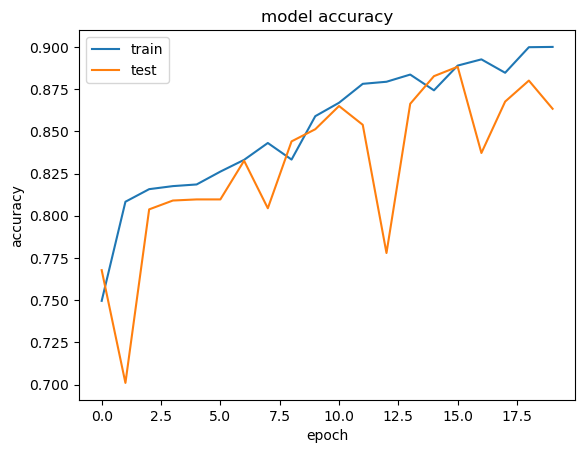

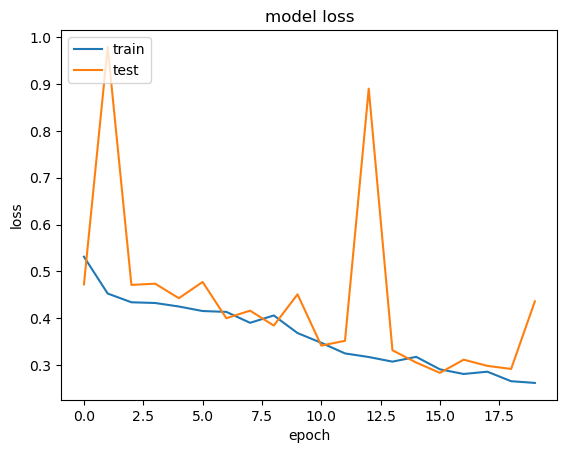

In [229]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

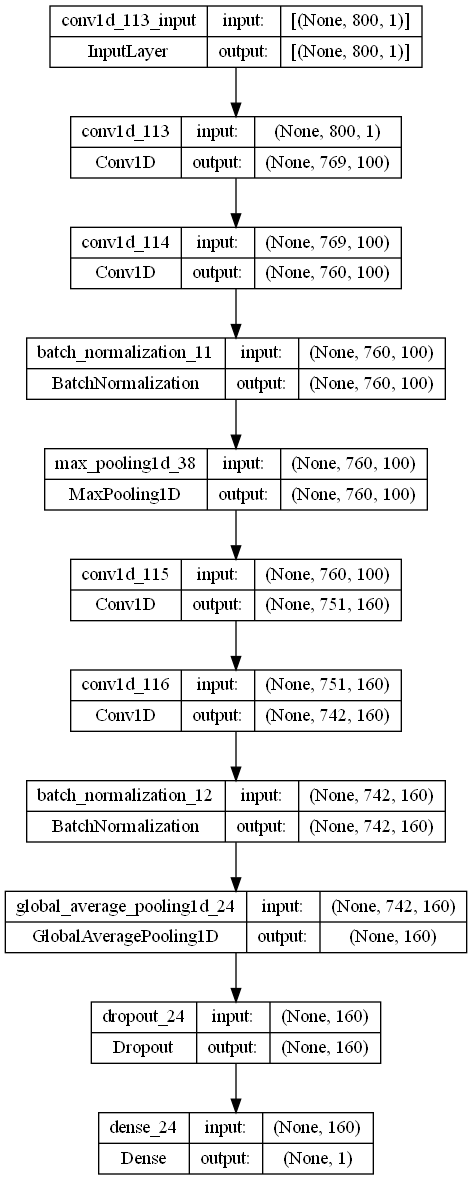

In [236]:
from keras.utils.vis_utils import model_to_dot
import keras
keras.utils.vis_utils.pydot = pydot
plot`_model(model_m, to_file='model.png', show_shapes=True, show_layer_names=True)
# keras.utils.plot_model(
#     model_m,
#     to_file="model.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=False
# )


In [17]:
# Load the previously saved weights
model_m.load_weights("best_model.03-0.79.h5")

# Re-evaluate the model
loss, acc = model_m.evaluate(input_test, truth_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))


ValueError: Layer count mismatch when loading weights from file. Model expected 7 layers, found 5 saved layers.

In [62]:
#model_m.predict(input_test)
for i in range(0, 1):#dla_seg.shape[0]):
    A = dla_seg[i]
    B = X_mean[i]
    N = len(A)
    possibles = np.where(B == A[0])[0]
    print(possibles)
    solns = []
    for p in possibles:
        check = B[p:p+N]
    if np.all(check == A):
        solns.append(p)

    print(solns)
    plt.plot(X_mean[i+1])
    plt.plot(dla_seg[i])


#pred = model_m.predict(input_test)
#find predictions = 1 and pair with input_test

#np.unique(res, return_counts=True)
print(x)


[]


NameError: name 'check' is not defined